##### download

In [504]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import math
from math import exp as exp
import numpy as np
from pyfod.fod import caputo
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from pyfod.fod import caputo
import networkx as nx
import pandas as pd

### signal transformation

### network consisted of memristors

##### smooth curve

In [770]:
class smooth_signal:
    spikes=None # spikes list
    # helpers for smoothing
    points=None 
    steps=None
    steps_broad=None
    max_t=None
    
    def __init__(self, spikes):
        self.spikes=spikes
        self.max_t = len(self.spikes)
        self.points=[]
        for i in range(self.max_t):
            self.points.append([i, self.spikes[i]])
            self.points.append([i+1, self.spikes[i]])   
        self.steps = []
        for i in range(1, len(self.points)):
            # находим ступеньки
            if (self.points[i-1][1]==1) and (self.points[i][1]==0):
                self.steps.append([(i//2 - 0.5, i//2 + 0.5), i//2, -1])
            elif (self.points[i-1][1]==0) and (self.points[i][1]==1):
                self.steps.append([(i//2 - 0.5, i//2 + 0.5), i//2, 1])
        self.steps_broad = []
        if len(self.steps)>1:
            self.steps_broad.append([(0, (self.steps[0][1] + self.steps[1][1])/2), self.steps[0][1], self.steps[0][2]])
            for i in range(1, len(self.steps)-1):
                self.steps_broad.append([((self.steps[i-1][1] + self.steps[i][1])/2, (self.steps[i][1] + self.steps[i+1][1])/2), self.steps[i][1], self.steps[i][2]])
            self.steps_broad.append([((self.steps[len(self.steps)-2][1] + self.steps[-1][1])/2, self.points[-1][0]), self.steps[-1][1], self.steps[-1][2]]) 

    # returns smooth curve points
    def sigmoid_spikes(self, t):
        for j in range(len(self.steps_broad)):
            if (self.steps_broad[j][0][0] <= t) and (self.steps_broad[j][0][1] >= t):
                if self.steps_broad[j][2] == -1:
                    return -1/(1 + np.exp(-1*((t - self.steps_broad[j][1])/0.2))) + 1
                else:
                    return 1/(1 + np.exp(-1*((t - self.steps_broad[j][1])/0.2)))
        #print(len(self.points),self.max_t, t, int(t)*2)
        if int(t)*2 >= len(self.points):
            points2=self.points.copy()
            while int(t)*2 >= len(points2):
                points2 += self.points
            return points2[int(t)*2][1]
        return self.points[int(t)*2][1]
    
    def draw_smooth(self):
        plt.plot(np.array(self.points).T[0],np.array(self.points).T[1]) 
        x=np.linspace(0,self.max_t,self.max_t*100,endpoint=False)
        sigmoid_f = np.array(list(map(self.sigmoid_spikes, x)))
        plt.plot(x, sigmoid_f, 'r--')
        
    def get_plot_curve(self):
        x=np.linspace(0,self.max_t,self.max_t*100,endpoint=False)
        sigmoid_f = np.array(list(map(self.sigmoid_spikes, x)))
        return np.array(self.points).T[0],np.array(self.points).T[1], x, sigmoid_f, 'r--'

In [767]:
a = smooth_signal([0,2,3,0,0,1,0,0,1,0]).points
len(a)

20

##### one single memristor

In [81]:
class memristor_fractional:
    u_Voltage=0
    u_Hz=0
    q=1
    gamma1=0
    gamma2=0
    delta1=0
    delta2=0
    x_p=0
    x_n=0
    A_p=0
    A_n=0
    V_p=0
    V_n=0
    x_arr=[]
    t_arr=[]
    u_arr=[]
    i_arr=[]
    counter=0
    x0=2
    from_number=0
    to_number=1
    amount=20
    
    alpha = 1
    x1=0
    
    spikes = []
    smooth_signal_spikes=None
    
    
    def clean(self):
        self.x_arr=[]
        self.t_arr=[]
        self.u_arr=[]
        self.i_arr=[]
        self.counter=0
        
    def set_params(self, spikes, q, gamma1, gamma2, delta1, delta2, x_p, x_n,  A_p, A_n, V_p, V_n, x0, from_number, to_number, amount, alpha):
        self.clean()
        
    
        self.q=q
        self.gamma1=gamma1
        self.gamma2=gamma2
        self.delta1=delta1
        self.delta2=delta2
        self.x_p=x_p
        self.x_n=x_n
        self.A_p=A_p
        self.A_n=A_n
        self.V_p=V_p
        self.V_n=V_n
        
        self.x0=x0
        self.to_number=to_number
        self.from_number=from_number
        self.amount=amount
        
        self.alpha = alpha 
        
        self.spikes=spikes
        self.smooth_signal_spikes=smooth_signal(spikes)
        
        
        # compute
        self.compute_state_equation()
        self.compute_current_voltage()
        
        

    def u(self, t):
        return self.smooth_signal_spikes.sigmoid_spikes(t)
    
    def exp_q(self, xx):
        if self.q==1:
            return exp(xx)
        elif (1+(1-self.q)*xx)>0:
            return (1+(1-self.q)*xx)**(1/(1-self.q))
        else:
            return 0
        
    def sinh_q(self, xx):
        return 0.5*(self.exp_q(xx)-self.exp_q(-1*xx))

    # u, x - functions with one single argument t
    def i(self, t):
        return self.gamma1*self.x(t)*self.sinh_q(self.delta1*self.u(t)) + self.gamma2*(1-self.x(t))*self.sinh_q(self.delta2*self.u(t))
    
    def w_p(self, x1, t):
        return 1+(self.x_p-x1)/(1-self.x_p)
    
    def w_n(self, x1, t):
        return x1/(1-self.x_n)
    
    # u,x - function with one single argument t
    def f(self, x1, t):
        if self.u(t) > 0:
            if x1>=self.x_p:
                #print(1)
                return exp(-1*(x1-self.x_p))*self.w_p(x1, t)
            else:
                #print(2)
                return 1
        else:
            if x1<=(1-self.x_n):
                #print(3)
                return exp(x1+self.x_n-1)*self.w_n(x1, t)
            else:
                #print(4)
                return 1
            
    def g(self, t):
        if self.u(t) > self.V_p:
            return self.A_p * (exp(self.u(t)) - exp(self.V_p))
        elif self.u(t)<(-1*self.V_n):
            return -1*self.A_n * (exp(-1*self.u(t)) - exp(self.V_n))
        else:
            return 0
    
    def func_caputo(self, t):
        return self.g(t) * self.f(self.x1, t)
    
    def dxdt(self, x1, t):
        self.x1=x1
        res=caputo(f=np.vectorize(self.func_caputo), alpha=1-self.alpha, lower=0, upper=t, quadrature='rs', n=25)['fd']
        #print(res, self.func_caputo(t), self.counter)
        self.counter = self.counter+1
        return res
        #return self.func_caputo(t)
    
    # computations---------------------------------------------------------------------------------------
    def compute_state_equation(self):
        t_arr = np.linspace(self.from_number, self.to_number, self.amount) # vector of time
        self.t_arr=t_arr
        x_arr = odeint(self.dxdt, self.x0, t_arr) # solve eq.
        x_arr = np.array(x_arr).flatten()
        self.x_arr=x_arr
        #for t in self.t_arr:
            #self.x_arr.append(self.u(t))
        
    def x(self, t):
        ind = list(self.t_arr).index(t)
        return self.x_arr[ind]
    
    def compute_current_voltage(self):
        for t in self.t_arr:
            self.i_arr.append(self.i(t))
            self.u_arr.append(self.u(t))

##### example: one single memristor 
* u-v curve
* signal transformaion

In [82]:
def current_voltage_plot_fractional(q, gamma1, gamma2, delta1, delta2, x_p, x_n, A_p, A_n, V_p, V_n, from_number, to_number, amount, alpha, x0, color):
    #print(u_Voltage, u_Hz, q, gamma1, gamma2, delta1, delta2, x_p, x_n,  A_p, A_n, V_p, V_n, x0, from_number, to_number, amount, alpha, color)
    memristor1.set_params(spikes, q, gamma1, gamma2, delta1, delta2, x_p, x_n,  A_p, A_n, V_p, V_n, x0, from_number, to_number, amount, alpha)
    plt.clf()
    plt.plot(memristor1.u_arr, memristor1.i_arr, 'o-', color=color) 
    plt.title(f'Model with derivative order = {alpha}')
    plt.xlabel('Voltage')
    plt.ylabel('Current')

memristor1=memristor_fractional()

spikes=[0,1,0,0,1,0,0,0,0,0,0,1,1,1,1,0,0,1,0,1,1,1,1]

interact_manual(current_voltage_plot_fractional, \
         q=0.726, gamma1=0.227, gamma2=0.001,\
         delta1=1.021, delta2=5.373,\
         x_p=0.21, x_n=0.571,  A_p=0.321, A_n=0.049,\
         V_p=4.543, V_n=0.0,\
         from_number=0.0, to_number=1, amount=(0, 100), alpha=0.95,\
         x0=(0,5,0.1),\
         color=["orange","red","yellow"])

interactive(children=(FloatSlider(value=0.726, description='q', max=2.178, min=-0.726), FloatSlider(value=0.22…

<function __main__.current_voltage_plot_fractional(q, gamma1, gamma2, delta1, delta2, x_p, x_n, A_p, A_n, V_p, V_n, from_number, to_number, amount, alpha, x0, color)>

Text(0, 0.5, 'U(t)/I(t)')

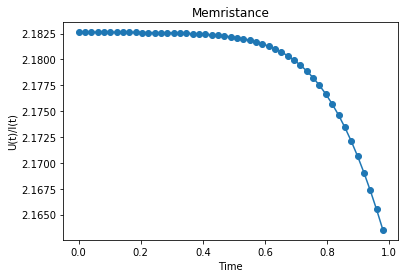

In [83]:
plt.plot(memristor1.t_arr[:-1], (np.array(memristor1.u_arr)/np.array(memristor1.i_arr))[:-1], 'o-')
plt.title('Memristance')
plt.xlabel('Time')
plt.ylabel('U(t)/I(t)')

##### if_neuron

In [153]:
class IF_neuron:
    
    threshold = None
    original_spikes=[]
    transformed_spikes=[]
    
    def __init__(self, threshold, original_spikes):
        self.threshold=threshold
        self.original_spikes=original_spikes
        self.transform()
    
    def transform(self):
        self.transformed_spikes=[]
        summ=0
        for i in range(len(self.original_spikes)):
            summ+=self.original_spikes[i]
            if summ >= self.threshold:
                self.transformed_spikes.append(1)
                summ=0
            else:
                self.transformed_spikes.append(0)


### Network

In [788]:
class neurons_graph(nx.DiGraph):
    
    memristors={} # nodes
    neurons={}
    signals=[] # edges
    time=0
    
    
    def clear(self):
        self.memristors={} # nodes
        self.neurons={}
        self.signals=[] # edges
        self.time=0
        
        
    def __init__(self):
        nx.DiGraph.__init__(self)
        self.clear()
        
        
    def add_weighted_edges_from(self, lst):
        super().add_weighted_edges_from(lst)
        for i in range(len(self.edges)):
            self.memristors[i]=memristor_fractional()
        
        
    
    def spikes_generator(self): 
        return np.random.randint(0, 2, self.time)

    
    def sum_signal(self, u_lst):
        res=np.array(u_lst[0])
        for i in range(1, len(u_lst)):
            res = res + np.array(u_lst[i])
        return res
     
    def find_children(self, lst_nodes):
        res=[]
        for node in lst_nodes:
            res+=list(self.successors(node))
        return list(set(res))
    
    def find_memristor_index(self, node1, node2):
        for i in range(len(self.edges)):
            if list(self.edges)[i][0]==node1 and list(self.edges)[i][1]==node2:
                return i
            
    def find_memristor_indices_for_node(self, node):
        res=[]
        for i in range(len(self.edges)):
            if list(self.edges)[i][0]==node:
                res.append(i)
        return res
    
    def find_parents(self, lst_nodes):
        res=[]
        for node in lst_nodes:
            res+=list(self.predecessors(node))
        return list(set(res))
            
    def launch(self, start_nodes, time, \
                  q=0.726, gamma1=0.227, gamma2=0.001,\
                 delta1=1.021, delta2=5.373,\
                 x_p=0.21, x_n=0.571,  A_p=0.321, A_n=0.049,\
                 V_p=4.543, V_n=0.0,\
                 from_number=0.0, to_number=1, amount=50, alpha=0.95,\
                 x0=2.5):
        
        self.time=time
        to_number=time
        amount=time
        
        # start nodes
        for node in start_nodes:
            self.neurons[node]=IF_neuron(2, self.spikes_generator())
            # затем заполняем все синапсы, для которых node первый 
            indices=self.find_memristor_indices_for_node(node)
            for memristor_ind in indices:
                self.memristors[memristor_ind].set_params(self.neurons[node].transformed_spikes,\
                                                          q, gamma1, gamma2, delta1, delta2,\
                                                          x_p, x_n,  A_p, A_n, V_p, V_n,\
                                                          x0, from_number, to_number, amount, alpha)
        
        
        while len(self.neurons) != len(self.nodes):
            print(len(self.neurons), len(self.nodes))
            flag=False
            
            # находим всех детей уже заполненных вершин
            children=self.find_children(self.neurons)
            children=[node for node in children if node not in self.neurons]
            
            # проверяем, есть ли среди детей хотя бы один, у которого заполнены все родители
            for child in children:
                if np.all([node in self.neurons for node in list(self.predecessors(child))]):
                    flag=True
                    # заполняем эту вершину
                    u_lst=[]
                    for pred_node in self.predecessors(child):
                        ind = self.find_memristor_index(pred_node, child)
                        u_lst.append(
                            np.array(self.neurons[pred_node].transformed_spikes)*np.array(self.memristors[ind].u_arr)/np.array(self.memristors[ind].i_arr)
                        )

                    self.neurons[child]=IF_neuron(2, \
                                        self.sum_signal(u_lst))
                    # затем заполняем все синапсы, для которых child первый 
                    indices=self.find_memristor_indices_for_node(child)
                    for memristor_ind in indices:
                        self.memristors[memristor_ind].set_params(self.neurons[child].transformed_spikes,\
                                                                  q, gamma1, gamma2, delta1, delta2,\
                                                                  x_p, x_n,  A_p, A_n, V_p, V_n,\
                                                                  x0, from_number, to_number, amount, alpha)
            if not flag:
                all_parents=self.find_parents(children)
                not_existing_nodes=[node for node in all_parents if node not in self.neurons]
                if len(not_existing_nodes)==0:
                    not_existing_nodes=[node for node in self.nodes if node not in self.neurons]
                random_node=np.random.choice(not_existing_nodes)
                self.neurons[random_node]=IF_neuron(2, self.spikes_generator())
                # затем заполняем все синапсы, для которых child первый 
                indices=self.find_memristor_indices_for_node(random_node)
                for memristor_ind in indices:
                    self.memristors[memristor_ind].set_params(self.neurons[random_node].transformed_spikes,\
                                                              q, gamma1, gamma2, delta1, delta2,\
                                                              x_p, x_n,  A_p, A_n, V_p, V_n,\
                                                              x0, from_number, to_number, amount, alpha)
     
    
    
                
    def draw_memristance(self, synapses):
        n = len(synapses)//2 + 1
        fig = plt.figure(figsize=(2.5*5, n*5))
        fig.suptitle("Memristance curve for synapses "+ ','.join(map(str,synapses)), fontsize=16)
        counter=1
        for synapse in synapses:
            ax = plt.subplot(n, 2, counter)
            time_array, memristance_array = self.memristors[synapse].t_arr, np.array(self.memristors[synapse].u_arr)/np.array(self.memristors[synapse].i_arr) 
            ax.plot(time_array, memristance_array, '-o', c='yellowgreen')
            alpha=self.memristors[synapse].alpha 
            ax.set_title('between nodes {} and {} (Alpha = {}).'.format(str(list(self.edges)[synapse][0]), str(list(self.edges)[synapse][1]), str(round(alpha,2))),\
                         fontsize=8)
            ax.set_xlabel('Time', fontsize=8)
            ax.set_ylabel('Memristance', fontsize=8)
            counter+=1
            
        
    def draw_current_voltage(self, synapses, line_type, color):
        n = len(synapses)//2 + 1
        fig = plt.figure(figsize=(2.5*5, n*5))
        fig.suptitle("Current-Voltage curve for synapses "+ ','.join(map(str,synapses)), fontsize=16)
        counter=1
        for synapse in synapses:
            ax = plt.subplot(n, 2, counter)
            current, voltage = self.memristors[synapse].i_arr,self.memristors[synapse].u_arr 
            ax.plot(current, voltage, line_type, c=color)
            alpha=self.memristors[synapse].alpha 
            ax.set_title('between nodes {} and {} (Alpha = {}).'.format(str(list(self.edges)[synapse][0]), str(list(self.edges)[synapse][1]), str(round(alpha,2))),\
                         fontsize=8)
            ax.set_xlabel('Current', fontsize=8)
            ax.set_ylabel('Voltage', fontsize=8)
            counter+=1
            
    def draw_input_output_current(self, node):
        ind=list(self.nodes).index(node)
        plt.figure(figsize=(10, 4))
        points1, points2, x, sigm, color = smooth_signal(self.neurons[node].original_spikes).get_plot_curve()
        plt.subplot(1, 2, 1)
        plt.plot(points1, points2)
        plt.plot(x, sigm, color)
        plt.title('Node ' + str(node) + '. Original signal.' )
        
        points1, points2, x, sigm, color = smooth_signal(self.neurons[node].transformed_spikes).get_plot_curve()
        plt.subplot(1, 2, 2)
        plt.plot(points1, points2)
        plt.plot(x, sigm, color)
        plt.title('Node ' + str(node) + '. Transformed signal.' )
       
            
            

### Testing

In [682]:
edges=[]
for i in range(10):
    edges.append([np.random.randint(1,4), np.random.randint(5,9), np.random.randint(100,200)])

In [789]:
test_graph=neurons_graph()
test_graph.add_weighted_edges_from(edges)

In [790]:
test_graph.launch([1,2], time=50)

2 7
3 7
4 7


In [799]:
test_graph.neurons

{1: <__main__.IF_neuron at 0x219b8d576d8>,
 2: <__main__.IF_neuron at 0x219b8d57470>,
 7: <__main__.IF_neuron at 0x219b8d5f400>,
 3: <__main__.IF_neuron at 0x219b8d5f588>,
 8: <__main__.IF_neuron at 0x219b8d69a20>,
 5: <__main__.IF_neuron at 0x219b8d69b00>,
 6: <__main__.IF_neuron at 0x219b8d69470>}

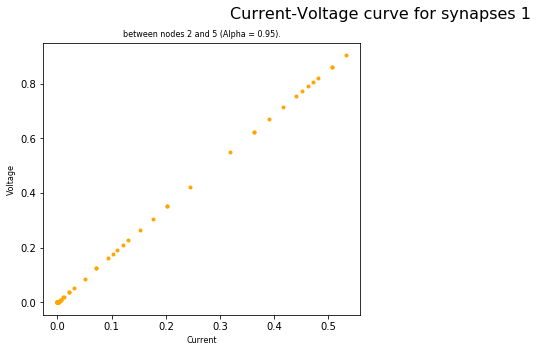

In [791]:
test_graph.draw_current_voltage([1], '.', 'orange')

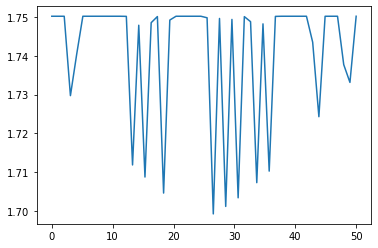

In [792]:
plt.plot(test_graph.memristors[3].t_arr, np.array(test_graph.memristors[3].u_arr)/np.array(test_graph.memristors[3].i_arr))

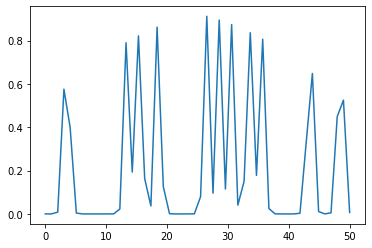

In [793]:
plt.plot(test_graph.memristors[1].t_arr, np.array(test_graph.memristors[3].u_arr))

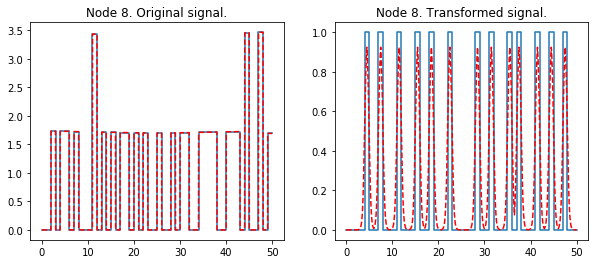

In [803]:
test_graph.draw_input_output_current(8)

# C Elegans

In [752]:
celegans = pd.read_csv('optic_edges2.txt', delimiter=' ', names = ['from', 'to', 'str','weight'])
celegans = celegans[celegans['from'] != celegans['to']] # без петель
celegans = celegans.drop('str', 1) # удалим столбец
celegans.head()

,from,to,weight
0,I1L,I6,1
1,I1L,pm4D,1
2,I1R,I3,1
3,I1R,M1,1
4,I1R,M2L,1


In [804]:
cel=neurons_graph()
cel.add_weighted_edges_from(celegans.values)

In [805]:
starts = np.array(cel.nodes)[(np.array([len(list(cel.predecessors(node)))for node in np.array(cel.nodes)]) == 0)]
starts

array(['ASIR', 'IL2DR', 'AINL', 'ALA', 'CEMDR', 'ASJL', 'URYDL'],
      dtype='<U10')

In [806]:
cel.launch(starts, time=50)

7 559
10 559
11 559
12 559
13 559
14 559
15 559
16 559
17 559
18 559
19 559
20 559
21 559
22 559
23 559
24 559
25 559
26 559
27 559
28 559
29 559
30 559
31 559
32 559
33 559
34 559
35 559
36 559
37 559
38 559
39 559
40 559
41 559
42 559
43 559
44 559
45 559
46 559
47 559
48 559
49 559
50 559
51 559
52 559
53 559
54 559
55 559
56 559
57 559
58 559
59 559
60 559
61 559
62 559
63 559
64 559
65 559
66 559
67 559
68 559
69 559
70 559
71 559
72 559
73 559
74 559
75 559
76 559
77 559
78 559
79 559
80 559
81 559
82 559
83 559
84 559
85 559
86 559
87 559
88 559
89 559
90 559
91 559
92 559
93 559
94 559
95 559
96 559
97 559
98 559
99 559
100 559
101 559
102 559
103 559
104 559
105 559
106 559
107 559
108 559
109 559
110 559
111 559
112 559
113 559
114 559
115 559
116 559
117 559
118 559
119 559
120 559
121 559
122 559
123 559
124 559
125 559
126 559
127 559
128 559
129 559
130 559
131 559
132 559
133 559
134 559


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in true_divide


135 559
136 559
137 559
138 559
139 559
140 559
141 559
142 559
143 559
144 559
145 559
146 559
147 559
148 559
149 559
150 559
151 559
152 559
153 559
154 559
155 559
156 559
157 559
158 559
159 559
160 559
161 559
162 559
163 559
164 559
165 559
166 559
167 559
168 559
169 559
170 559
171 559
172 559
173 559
174 559
175 559
177 559
178 559
179 559
180 559
181 559
182 559
183 559
184 559
185 559
186 559
187 559
188 559
189 559
190 559
191 559
192 559
193 559
194 559
195 559
196 559
197 559
198 559
199 559
200 559
201 559
202 559
203 559
204 559
205 559
206 559
207 559
208 559
209 559
210 559
211 559
212 559
213 559
214 559
215 559
216 559
217 559
218 559
219 559
220 559
221 559
222 559
223 559
224 559
225 559
226 559
227 559
228 559
229 559
230 559
231 559
232 559
233 559
234 559
235 559
236 559
238 559
239 559
240 559
242 559
243 559
244 559
245 559
246 559
247 559
248 559
249 559
250 559
251 559
253 559
254 559
256 559
257 559
258 559
259 559
260 559
261 559
262 559
263 559
264 559


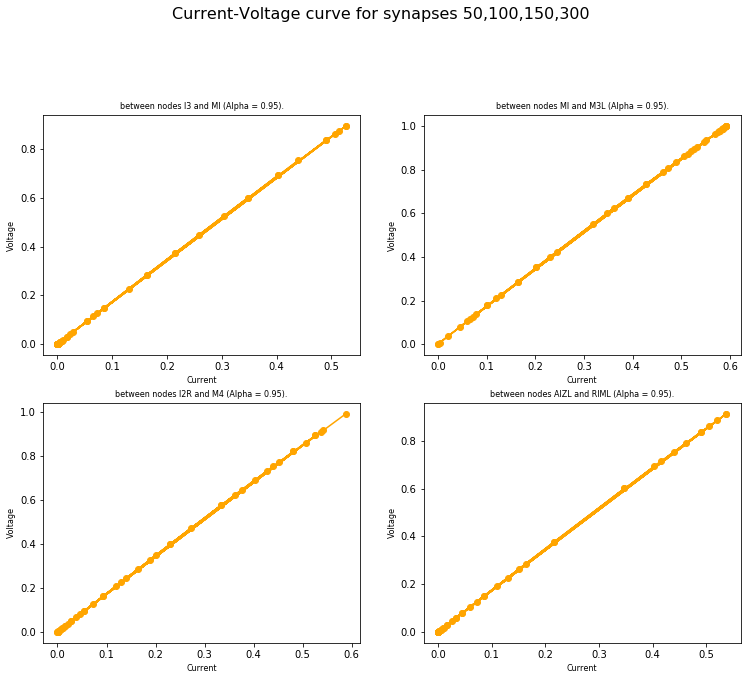

In [810]:
cel.draw_current_voltage([50,100,150,300], '-o', 'orange')

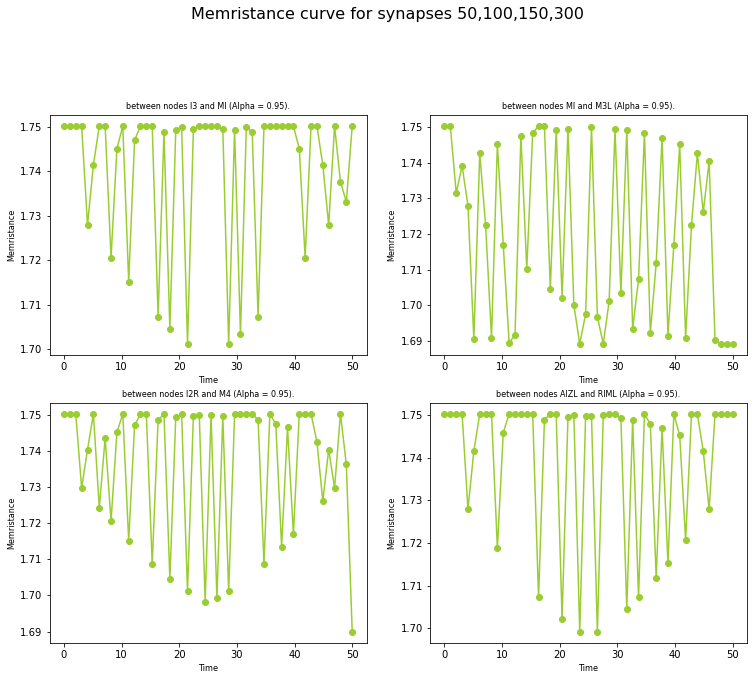

In [811]:
cel.draw_memristance([50,100,150,300])

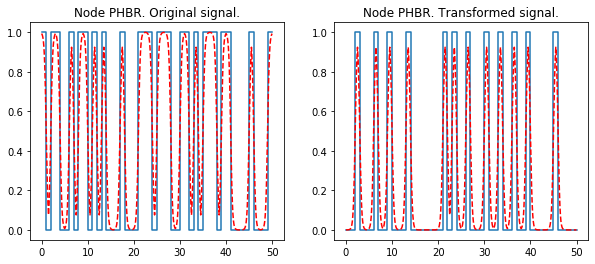

In [812]:
cel.draw_input_output_current(np.random.choice(cel.nodes))

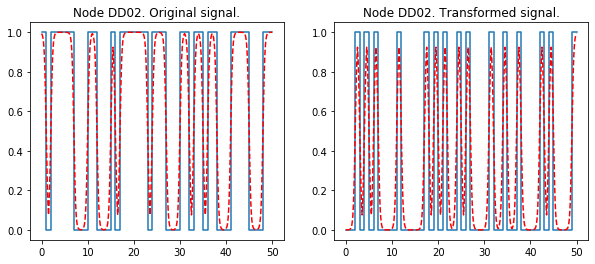

In [813]:
cel.draw_input_output_current(np.random.choice(cel.nodes))

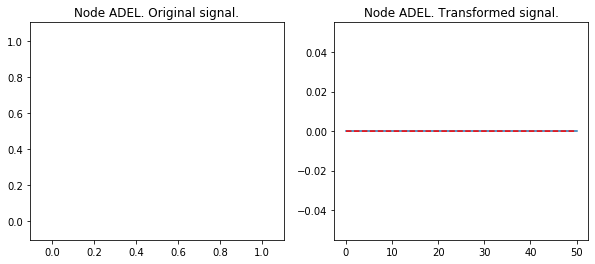

In [814]:
cel.draw_input_output_current(np.random.choice(cel.nodes))

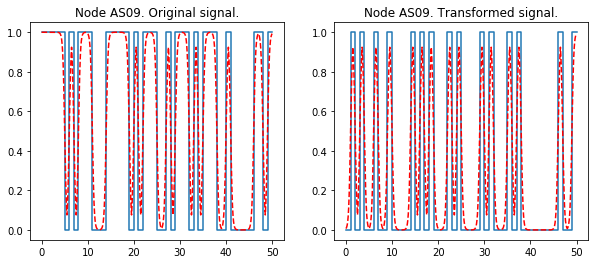

In [815]:
cel.draw_input_output_current(np.random.choice(cel.nodes))

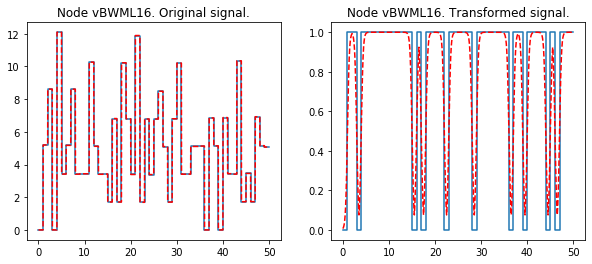

In [816]:
cel.draw_input_output_current(np.random.choice(cel.nodes))

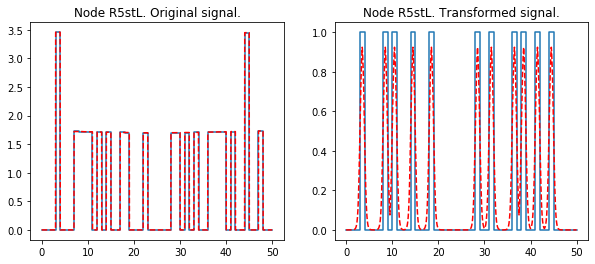

In [817]:
cel.draw_input_output_current(np.random.choice(cel.nodes))

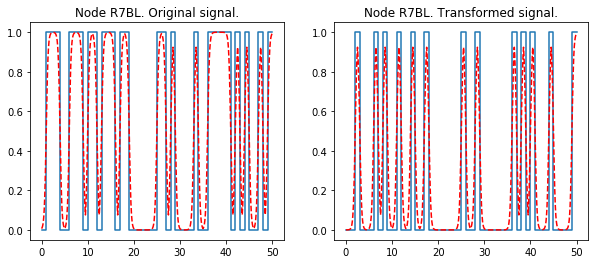

In [818]:
cel.draw_input_output_current(np.random.choice(cel.nodes))

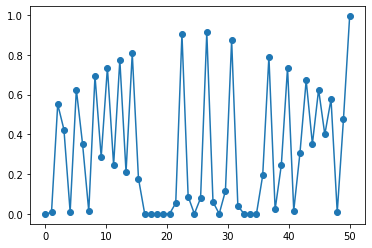

In [820]:
plt.plot(cel.memristors[100].t_arr, cel.memristors[0].u_arr, '-o')

In [569]:
cel.time

50